# Convolutional Neural Network

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]
Pandas 1.4.3
Scikit-Learn 1.1.1
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import os

##  VGG16

In [3]:
import tensorflow.keras as keras

vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [4]:
import matplotlib.pyplot as plt
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    path_dir = '../../dataset/train'
    parth_dir_test = '../../dataset/test'

    datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.2)

    train_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(150,150),
        shuffle=True,
        subset='training',
        batch_size = 64,
        class_mode = 'binary'
    )
    
    val_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(150,150),
        subset='validation',
        batch_size = 64,
        class_mode = 'binary'
    )

    test_dataset = datagen.flow_from_directory(parth_dir_test,
                                        target_size= (150,150),
                                        batch_size = 64,
                                        class_mode = 'binary',
                                        shuffle=False)
    return train_dataset, val_dataset, test_dataset

In [20]:
train_dataset, val_dataset, test_dataset = generators((150,150), preprocessing=vgg16.preprocess_input)

Found 2202 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 688 images belonging to 2 classes.


In [7]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [8]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)

# final softmax layer
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
for layer in conv_model.layers:
    layer.trainable = False

In [10]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime

#rm -rf /logs/

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_vgg16.h5', monitor='val_loss', mode='min', save_best_only=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20)

# Create a TensorBoard callback
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    callbacks = [tensorboard_callback,es,mc,reduceLR],
    epochs=35
)

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
35/35 [==============================] - 22s 396ms/step - loss: 0.6367 - acc: 0.6421 - val_loss: 0.5608 - val_acc: 0.8309
Epoch 2/35
35/35 [==============================] - 8s 216ms/step - loss: 0.5189 - acc: 0.7802 - val_loss: 0.4458 - val_acc: 0.8600
Epoch 3/35
35/35 [==============================] - 8s 219ms/step - loss: 0.4471 - acc: 0.8279 - val_loss: 0.3772 - val_acc: 0.8745
Epoch 4/35
35/35 [==============================] - 7s 212ms/step - loss: 0.3921 - acc: 0.8479 - val_loss: 0.3452 - val_acc: 0.8655
Epoch 5/35
35/35 [==============================] - 7s 211ms/step - loss: 0.3574 - acc: 0.8610 - val_loss: 0.3204 - val_acc: 0.8691
Epoch 6/35
35/35 [==============================] - 7s 212ms/step - loss: 0.3385 - acc: 0.8688 - val_loss: 0.2924 - val_acc: 0.8927
Epoch 7/35
35/35 [==============================] - 7s 212ms/step - loss: 0.3163 - acc: 0.8733 - val_loss: 0.2827 - val_acc: 0.8909
Epoch 8/35
35/35 [==============================] - 8s 215ms/step - loss: 0

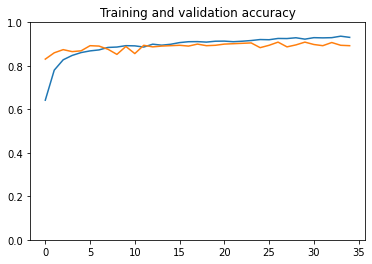

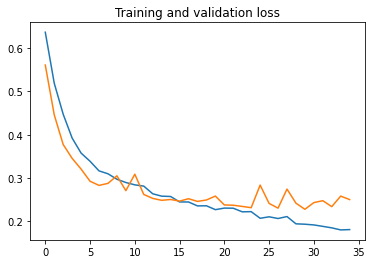

In [14]:
plot_history(history, yrange=(0,1))

In [15]:
%tensorboard --logdir logs/fit

In [16]:
full_model.load_weights('best_vgg16.h5')

In [21]:
test_model = full_model.load_weights('best_vgg16.h5')

In [23]:
Y_pred = full_model.predict_generator(test_dataset, test_dataset.samples // test_dataset.batch_size)
Y_pred

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0.25875217],
       [0.06615838],
       [0.05303687],
       [0.03565032],
       [0.03682791],
       [0.21451384],
       [0.15280415],
       [0.19826117],
       [0.07484489],
       [0.05632036],
       [0.04572728],
       [0.14186926],
       [0.05028199],
       [0.07682029],
       [0.01817393],
       [0.02826154],
       [0.04634168],
       [0.4217715 ],
       [0.1063908 ],
       [0.04984231],
       [0.0366298 ],
       [0.03043098],
       [0.1676509 ],
       [0.03911208],
       [0.09237797],
       [0.15788661],
       [0.07577689],
       [0.05977419],
       [0.05737253],
       [0.03807099],
       [0.04257024],
       [0.05818539],
       [0.04319995],
       [0.10890147],
       [0.06484909],
       [0.01831013],
       [0.02149642],
       [0.01027155],
       [0.01877405],
       [0.61257035],
       [0.607394  ],
       [0.00701761],
       [0.00768963],
       [0.04438974],
       [0.01772168],
       [0.06803147],
       [0.10026875],
       [0.013

In [17]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [25]:
score = full_model.evaluate(test_dataset, verbose=0)

print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 0.18763229250907898
Test accuracy 0.9316860437393188


In [26]:
#Overfitting -> Your training accuracy will be higher than the accuracy on the validation/test set

#Overfitting indicates that your model is too complex for the problem that it is solving,
#filters in the case of Convolutional Neural Networks, and layers in the case of overall Deep Learning Models

#How do you know if your model is underfitting? Your model is underfitting if the accuracy on the validation set 
#is higher than the accuracy on the training set. Additionally, 
#if the whole model performs bad this is also called underfitting.

#https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d

In [28]:
import numpy as np
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,